## Computer Vision

### Assignment 01 - Assembling Lego Kits

STUDENTS

Name: Rui Filipe Castro Martins 202104636

Name: Rui Pedro Oliveira Sousa 202104673

---

Problem:

The Lego production factory needs to select the appropriate parts to include into different
kits. Visual data acquired from the production line must be analyzed to classify the types of
blocks. The factory relies on a computer vision system to automatically extract the following
properties:

- Identification of the size of each brick (e.g., 2x1, 2x2, etc.);
- Calculation of the average shape area of all bricks, in square millimeters, categorized
by color;
- Determination of the distribution of brick sizes and colors within the sample (e.g., total
number of red, blue, etc., and quantity of each size such as 2x1, 2x2).
- Verification of completeness: if any size or color required for kit assembly is missing,
the system must generate a warning in the format “Color (Size) XPTO is missing”.

Table 1 presents the standardized dimensions of Lego bricks in millimeters. The set of colors
considered includes white, blue, red, yellow, green, among others. The configuration of the
production line inspection system is illustrated in Figure 1

**Important:**
1. Identify the size
2. Calculate the average shape area of all bricks
3. Distribution of brick sizes and colors
4. Verify if the batch is completed

---

## Imports and Constants

In [1]:
# Get data
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Imports
import numpy as np
import cv2
import os
import pandas as pd
from collections import defaultdict
from matplotlib import pyplot as plt    # cv2.imshow() does not work. gotta use plt.imshow()

In [3]:
# Constants
LENGTH: int = 0
WIDTH: int  = 1
TABLE_OF_BRICKS: dict[str, list[int]] = {
    "2x1":  [32, 15],
    "2x2":  [32, 32],
    "2x4":  [32, 64],
    "2x6":  [32, 95],
    "R2x2": [32, 47]
}
# {"name": [length, width]}

FOLDER_PATH_DATA: str          = "/content/drive/Shareddrives/VCOM2526_Ruis/ASSIGNMENT_01/assign1_data/"
FOLDER_PATH_CALIBRATRION: str  = FOLDER_PATH_DATA + "Calibration/"
FOLDER_PATH_ISOLATED: str      = FOLDER_PATH_DATA + "Isolated/"
FOLDER_PATH_KIT: str           = FOLDER_PATH_DATA + "Kit/"
FOLDER_PATH_FAULT: str         = FOLDER_PATH_DATA + "Fault/"

CALIBRATION_GRID_ROWS: int     = 9  - 1 # Internal grid
CALIBRATION_GRID_COLUMNS: int  = 12 - 1 # Internal grid
CALIBRATION_GRID_SQR_SIZE: int = 15     # mm

COLOR_DICT: dict[str, tuple[float, float, float]] = {
    "white":  (53.33 , 8.74 , 80.78),
    "red":    (00.00 , 75.0 , 45.00), # Hue, Saturation, Value
    "green":  (100.0 , 50.0 , 50.00),
    "blue":   (209.25, 65.04, 48.24),
    "yellow": (42.17 , 66.67, 81.18)
}
# https://imagecolorpicker.com/
COLOR_RANGE_THRESHOLD: float   = 25.0
COLOR_RANGE_THRESHOLD_H: float = COLOR_RANGE_THRESHOLD / 2.0
COLOR_RANGE_THRESHOLD_S: float = COLOR_RANGE_THRESHOLD * 255.0 / 100
COLOR_RANGE_THRESHOLD_V: float = COLOR_RANGE_THRESHOLD * 255.0 / 100

CONTOUR_AREA_THRESHOLD: float  = 1000.0

---

## 1. Calibration images

a)

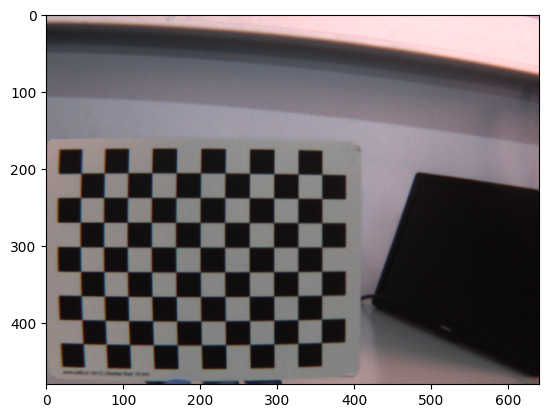

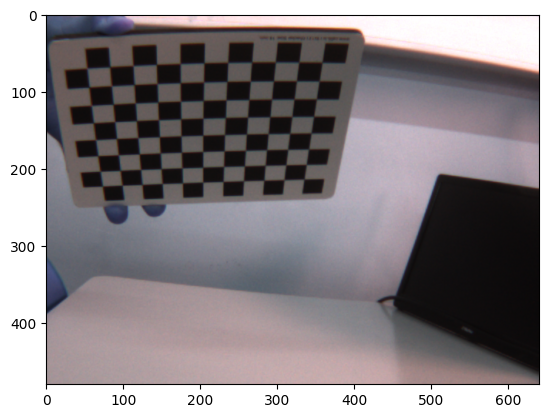

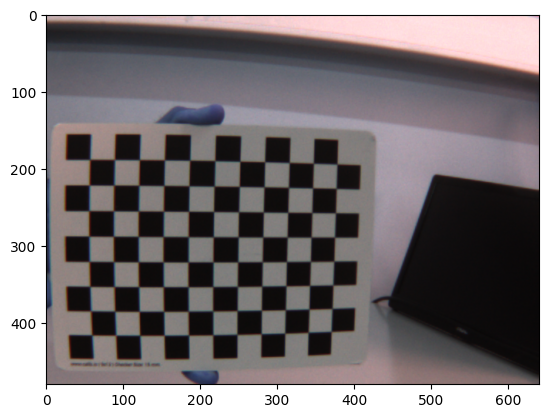

In [4]:
# Load images
dict_calib: dict[str, list[np.ndarray]] = {
    "calib1": [],
    "calib2": [],
    "calib3": []
}
num_calib: int = 3
for dir_num in range(num_calib):
    dir_path: str    = FOLDER_PATH_CALIBRATRION + f"calib{dir_num+1}/"
    directory: bytes = os.fsencode(dir_path)

    for file in os.listdir(directory):
        file_name: str = os.fsdecode(file)
        file_path: str = dir_path + file_name

        img_matrix     = cv2.imread(file_path)
        dict_calib[f"calib{dir_num+1}"].append(img_matrix)

        ## DEBUG ----
        if file_name == "calib_0.png":
            # cv2.imshow(f"{file_name}", img_matrix)
            plt.imshow(img_matrix)
            plt.show()
        ## DEBUG ----

## DEBUG ----
# print(f"{dict_calib["calib1"] = }")
# print(f"{dict_calib["calib2"] = }")
# print(f"{dict_calib["calib3"] = }")
## DEBUG ----



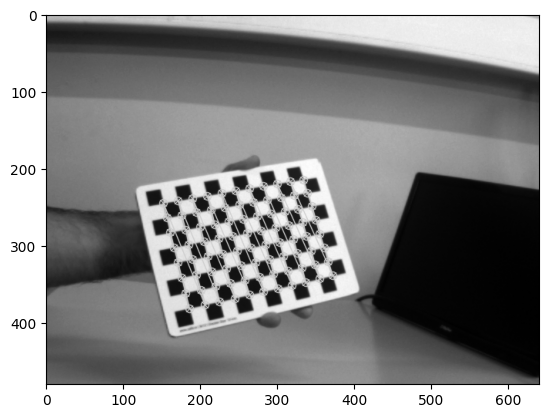

Camera intrinsic matrix: 
 [[829.98500877   0.         335.90216858]
 [  0.         829.92775038 280.79396727]
 [  0.           0.           1.        ]]
Lens distortion coeff: 
 [[-0.43648035  0.38599769 -0.00123406  0.00125542 -0.48157841]]
Re-projection error: 0.036587512275533196


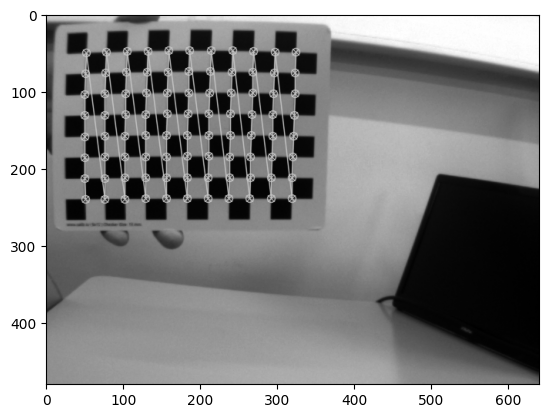

Camera intrinsic matrix: 
 [[835.95471886   0.         338.54138692]
 [  0.         836.13793608 277.87668312]
 [  0.           0.           1.        ]]
Lens distortion coeff: 
 [[-4.36217735e-01  3.42419212e-01 -4.94534953e-04  3.97196848e-04
  -3.39016109e-01]]
Re-projection error: 0.02186281268213948


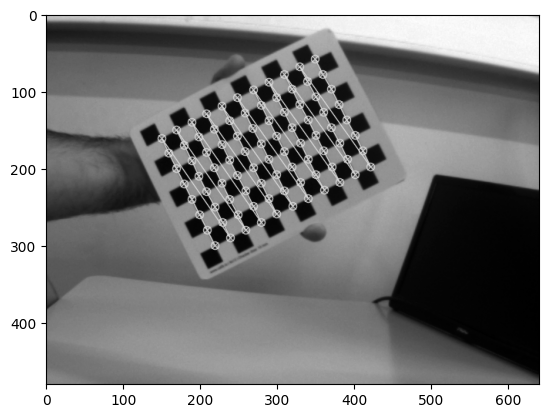

Camera intrinsic matrix: 
 [[836.50144767   0.         338.2790369 ]
 [  0.         836.67927841 277.34322766]
 [  0.           0.           1.        ]]
Lens distortion coeff: 
 [[-4.39651944e-01  3.67055096e-01 -4.34589488e-04  3.95803578e-04
  -3.98761425e-01]]
Re-projection error: 0.019486772424840693


In [5]:
# (https://docs.opencv.org/4.x/dc/dbb/tutorial_py_calibration.html)

# Termination criteria
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, CALIBRATION_GRID_SQR_SIZE, 0.001)

# Object points
objp       = np.zeros((CALIBRATION_GRID_ROWS*CALIBRATION_GRID_COLUMNS, 3), np.float32)
objp[:,:2] = np.mgrid[0:CALIBRATION_GRID_ROWS, 0:CALIBRATION_GRID_COLUMNS].T.reshape(-1,2)

objpoints = [] # 3d point in real world space
imgpoints = [] # 2d points in image plane

# Best calibration attempt
best_calib_attempt: dict[str, any] = {
    "intrinsic_matrix": [],
    "distortion_coeff": [],
    "reprojection_error": float("inf")
}

for attempt in dict_calib.values():
    i: int = 0

    for img in attempt:
        img_gray     = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Find chess board corners
        ret, corners = cv2.findChessboardCorners(
                            img_gray,
                            (CALIBRATION_GRID_ROWS, CALIBRATION_GRID_COLUMNS),
                            None
                        )

        if ret == True:
            objpoints.append(objp)

            corners2 = cv2.cornerSubPix(
                img_gray,
                corners,
                (11,11),
                (-1,-1),
                criteria
            )
            imgpoints.append(corners2)

            # Draw the corners
            cv2.drawChessboardCorners(
                img_gray,
                (CALIBRATION_GRID_ROWS, CALIBRATION_GRID_COLUMNS),
                corners2,
                ret
            )
            if i==0: plt.imshow(img_gray, cmap="gray"); plt.show(); i += 1

    # Calibration
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(
                                        objpoints,
                                        imgpoints,
                                        img_gray.shape[::-1],
                                        None,
                                        None
                                    )

    print( "Camera intrinsic matrix: \n {}".format(mtx) )
    print( "Lens distortion coeff: \n {}".format(dist) )

    # Reprojection error
    mean_error = 0
    for i in range(len(objpoints)):
        imgpoints2, _  = cv2.projectPoints(objpoints[i], rvecs[i], tvecs[i], mtx, dist)
        error          = cv2.norm(imgpoints[i], imgpoints2, cv2.NORM_L2)/len(imgpoints2)
        mean_error    += error

    reprojection_error = mean_error/len(objpoints)
    print( "Re-projection error: {}".format(reprojection_error) )

    # Store best calibration attempt
    if (reprojection_error) < best_calib_attempt["reprojection_error"]:
        best_calib_attempt["intrinsic_matrix"]   = mtx
        best_calib_attempt["distortion_coeff"]   = dist
        best_calib_attempt["reprojection_error"] = mean_error/len(objpoints)


**Justification**

Calibration 3 was selected as the best because it achieved the lowest re-projection error (0.0195 pixels), indicating the most accurate mapping between 3D world points and their 2D image projections. This lower error means better geometric accuracy for downstream measurements such as brick size estimation and pixel-to-millimeter conversion.

b)

In [6]:
# Auxiliary functions
def undistort_image(image: cv2.Mat, camera_intrinsic_matrix, camera_distortion_coeff, crop: bool = False, debug: bool = False) -> cv2.Mat:
    # Vars
    ### NOTE: We gotta check if the values are not NONE
    img  = image
    mtx  = camera_intrinsic_matrix
    dist = camera_distortion_coeff

    # Params
    h, w = img.shape[:2]
    newcameramtx, roi = cv2.getOptimalNewCameraMatrix(mtx, dist, (w,h), 1, (w,h))

    # Undistort
    img_undist  = cv2.undistort(img, mtx, dist, None, newcameramtx)

    # Crop the image
    if crop:
        x, y, w, h  = roi
        img_undist  = img_undist[y:y+h, x:x+w]

    ## DEBUG ----
    if debug:
        print("Original image: ")
        plt.imshow(img, cmap="gray")
        plt.show()

        print("Undistorted image: ")
        plt.imshow(img_undist, cmap="gray")
        plt.show()
    ## DEBUG ----

    return img_undist

Original image: 


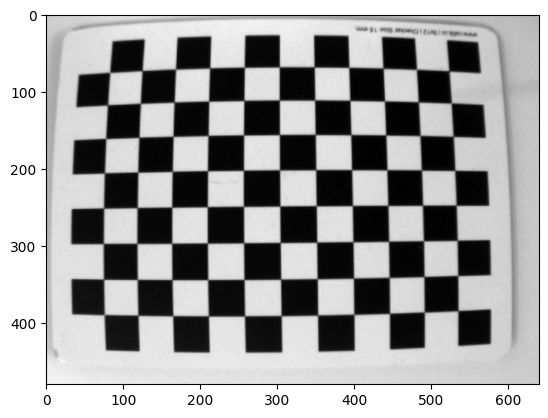

Undistorted image: 


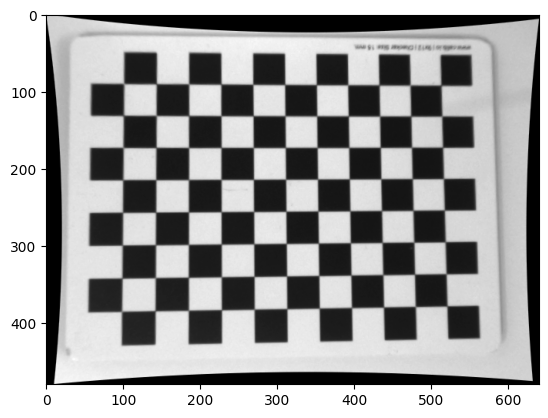


Extrinsic Matrix:
 [[ 1.21684358e-02 -9.95137100e-01 -9.77449826e-02  4.29765912e+00]
 [ 9.99302674e-01  8.65169393e-03  3.63223637e-02 -4.54416950e+00]
 [-3.53000720e-02 -9.81188089e-02  9.94548442e-01  2.01435390e+01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]

Px-to-mm conversion factor: 0.360317 mm/px


In [7]:
# Final inspection arrangement
img  = cv2.imread(f'{FOLDER_PATH_CALIBRATRION}final_setup.png', cv2.IMREAD_GRAYSCALE)

img_undist = undistort_image(
    img,
    best_calib_attempt["intrinsic_matrix"],
    best_calib_attempt["distortion_coeff"],
    debug=True
)

# Find chess board corners
ret, corners = cv2.findChessboardCorners(
                    img_undist,
                    (CALIBRATION_GRID_ROWS, CALIBRATION_GRID_COLUMNS),
                    None
)

if ret == True:
    corners2 = cv2.cornerSubPix(
        img_undist,
        corners,
        (5,5),
        (-1,-1),
        criteria
    )

    _, rvecs, tvecs = cv2.solvePnP(
                            objp,
                            corners2,
                            best_calib_attempt["intrinsic_matrix"],
                            best_calib_attempt["distortion_coeff"]
                        )

    rmtx, _ = cv2.Rodrigues(rvecs)

    # Extrinsic matrix
    extrinsic = np.eye(4)
    extrinsic[:3, :3] = rmtx
    extrinsic[:3, 3]  = tvecs.flatten()

    print("\nExtrinsic Matrix:\n", extrinsic)

    # Pixel-to-mm conversion using chessboard spacing
    distances_px = []

    # Horizontal neighbor distances
    for i in range(CALIBRATION_GRID_COLUMNS):
        for j in range(CALIBRATION_GRID_ROWS - 1):
            distances_px.append(np.linalg.norm(corners2[CALIBRATION_GRID_ROWS*i + j] - corners2[CALIBRATION_GRID_ROWS*i + (j+1)]))

    # Vertical neighbor distances
    for i in range(CALIBRATION_GRID_ROWS):
        for j in range(CALIBRATION_GRID_COLUMNS - 1):
            distances_px.append(np.linalg.norm(corners2[CALIBRATION_GRID_ROWS*j + i] - corners2[CALIBRATION_GRID_ROWS*(j+1) + i]))

    mean_px = np.mean(distances_px)  # mean pixel distance between adjacent inner corners
    mm_per_px = CALIBRATION_GRID_SQR_SIZE / mean_px

    print(f"\nPx-to-mm conversion factor: {mm_per_px:.6f} mm/px")


## NOTES: Pixel-to-millimeter conversion and extrinsics computed above when chessboard is detected.

---

## 2. Isolated brick images

a) and b)

### Quick Notes on the auxiliary functions

-> clamp: clamps the input value according to the min and max values.

-> color_range: converts HSV values into OpenCV's HSV compatible values and defines a range according to a threshold.

-> edge_detect: detects the edges and connects close edges together. It increases the minimum area of the connected components at each iteration as a way to filter which of those components are bricks and which are simply noise. At the end, smooths the mask to avoid shard edges and preserve the natural curvature.

In [8]:
# Auxiliary functions
def clamp(value: float, min_value: float = 0.0, max_value: float = 255.0) -> float:
    return max(min_value, min(value, max_value))

def color_range(hsv_value: tuple[float, float, float]) -> tuple[np.ndarray, np.ndarray]:
    hsv_value: tuple[float, float, float]   = (
        hsv_value[0] / 2.0,             # Hue        0 to 179
        hsv_value[1] * 255.0 / 100.0,   # Saturation 0-100% to 0-255
        hsv_value[2] * 255.0 / 100.0    # Value      0-100% to 0-255
    )
    lower_bound: np.ndarray = np.array([
        clamp(hsv_value[0] - COLOR_RANGE_THRESHOLD_H, max_value=179),
        clamp(hsv_value[1] - COLOR_RANGE_THRESHOLD_S),
        clamp(hsv_value[2] - COLOR_RANGE_THRESHOLD_V)
    ])
    upper_bound: np.ndarray = np.array([
        clamp(hsv_value[0] + COLOR_RANGE_THRESHOLD_H, max_value=179),
        clamp(hsv_value[1] + COLOR_RANGE_THRESHOLD_S),
        clamp(hsv_value[2] + COLOR_RANGE_THRESHOLD_V)
    ])

    return lower_bound, upper_bound

def edge_detect(img_original_hsv: cv2.Mat, min_component_area: int = 50, num_attempts: int = 3, debug: bool = False):
    # https://opencv.org/blog/edge-detection-using-opencv

    # Grayscale
    img_gray  = cv2.cvtColor(cv2.cvtColor(img_original_hsv, cv2.COLOR_HSV2BGR), cv2.COLOR_BGR2GRAY)

    # Equalize
    # https://docs.opencv.org/4.x/d5/daf/tutorial_py_histogram_equalization.html
    clahe     = cv2.createCLAHE(clipLimit=0.25, tileGridSize=(8,8))
    equalized = clahe.apply(img_gray)

    equalized = cv2.equalizeHist(equalized)

    gamma     = 0.5
    inv_gamma = 1.0 / gamma
    lut       = np.array([((i / 255.0) ** inv_gamma) * 255 for i in range(256)], dtype=np.uint8)
    equalized = cv2.LUT(equalized, lut)

    # Blurr
    blurred   = cv2.GaussianBlur(equalized, (7, 7), 0)  # Reduce noise

    ## DEBUG ----
    if debug:
        plt.imshow(blurred, cmap='gray')
        plt.title("Edges - Gray Image Blurred")
        plt.show()
    ## DEBUG ----

    # Sobel edge detection
    sobelx   = cv2.Sobel(blurred, cv2.CV_64F, 1, 0, ksize=3)
    sobely   = cv2.Sobel(blurred, cv2.CV_64F, 0, 1, ksize=3)
    sobel    = cv2.magnitude(sobelx, sobely)
    sobel    = cv2.convertScaleAbs(sobel)

    # Edge threshold
    mean_edge = np.mean(sobel) * 3.5
    sobel[sobel <= mean_edge] = 0
    sobel[sobel >  mean_edge] = 255

    ## DEBUG ----
    if debug:
        plt.imshow(sobel, cmap='gray')
        plt.title("Edges - Sobel")
        plt.show()
    ## DEBUG ----

    # Erosion and Dilation
    # https://docs.opencv.org/3.4/db/df6/tutorial_erosion_dilatation.html

    kernel  = np.ones((3, 3), np.uint8)
    binary  = cv2.dilate(sobel, kernel, iterations=1)

    kernel  = np.ones((3, 3), np.uint8)
    binary  = cv2.erode(binary, kernel, iterations=3)

    ## DEBUG ----
    if debug:
        plt.imshow(binary, cmap='gray')
        plt.title("Edges - Erosion and Dilation")
        plt.show()
    ## DEBUG ----

    # Connected Components
    # Get areas
    retval, labels, stats, centroids = cv2.connectedComponentsWithStats(
        binary, connectivity=8
    )
    areas   = stats[:, cv2.CC_STAT_AREA]

    # Build Overall Mask
    overall_mask                    = np.zeros_like(binary)
    individual_masks: list[cv2.Mat] = []
    for num_att in range(1, num_attempts+1):
        overall_mask                = np.zeros_like(binary)

        # Get min areas
        for i in range(1, retval):
            if areas[i] >= (min_component_area * num_att):
                component_mask              = np.zeros_like(binary)
                component_mask[labels == i] = 255

                individual_masks.append(component_mask)
                overall_mask  |= component_mask

        # Connect closest pixels
        kernel         = np.ones((5, 5), np.uint8)
        overall_mask   = cv2.morphologyEx(overall_mask, cv2.MORPH_CLOSE, kernel, iterations=10)

        # Get areas for next iter
        retval, labels, stats, centroids = cv2.connectedComponentsWithStats(
            overall_mask, connectivity=8
        )
        areas          = stats[:, cv2.CC_STAT_AREA]

        ## DEBUG ----
        if debug:
            plt.imshow(overall_mask, cmap='gray')
            plt.title(f"Edges - Connected Components {num_att}")
            plt.show()
        ## DEBUG ----

    # Smooth mask
    overall_mask = cv2.GaussianBlur(overall_mask, (61, 61), 0)
    overall_mask = cv2.threshold(overall_mask, 127, 255, cv2.THRESH_BINARY)[1]
    kernel       = np.ones((31, 31), np.uint8)
    overall_mask = cv2.dilate(overall_mask, kernel, iterations=1)

    ## DEBUG ----
    if debug:
        # Final result
        plt.imshow(overall_mask, cmap='gray')
        plt.title('Edges - Only Large Components')
        plt.show()

        # Canny edge detection - For comparison
        canny = cv2.Canny(blurred, threshold1=50, threshold2=100)

        plt.imshow(canny, cmap='gray')
        plt.title("Edges - Canny")
        plt.show()
    ## DEBUG ----

    return overall_mask

Color mask: white


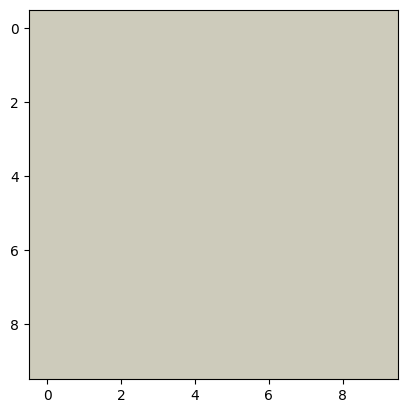

Color mask: red


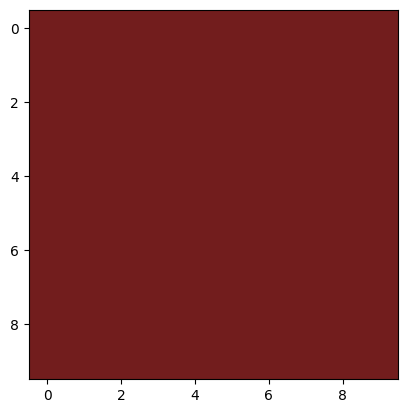

Color mask: green


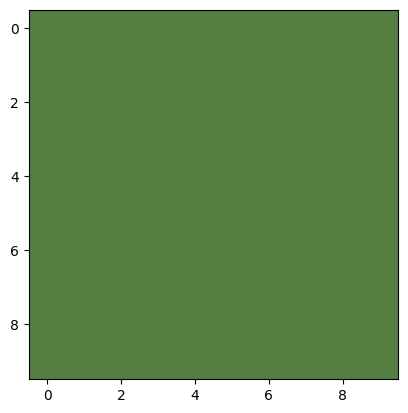

Color mask: blue


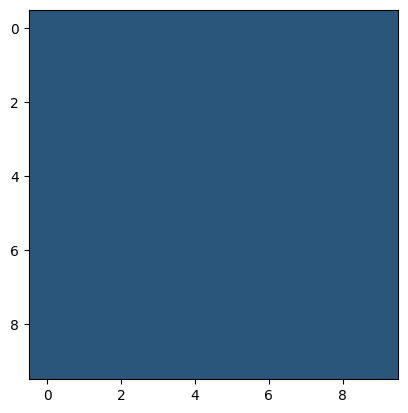

Color mask: yellow


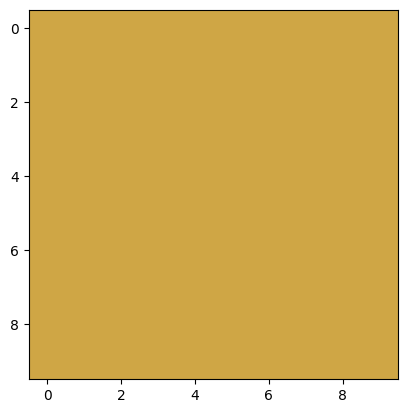

In [9]:
## DEBUG ----
for color_name, hsv_value in COLOR_DICT.items():
    hsv_img = np.zeros((10, 10, 3), dtype=np.uint8)
    hsv_img[..., 0] = hsv_value[0] / 2
    hsv_img[..., 1] = hsv_value[1] * 255 / 100
    hsv_img[..., 2] = hsv_value[2] * 255 / 100

    print(f"Color mask: {color_name}")
    plt.imshow( cv2.cvtColor(hsv_img, cv2.COLOR_HSV2RGB) )
    plt.show()
## DEBUG ----

Original image: 


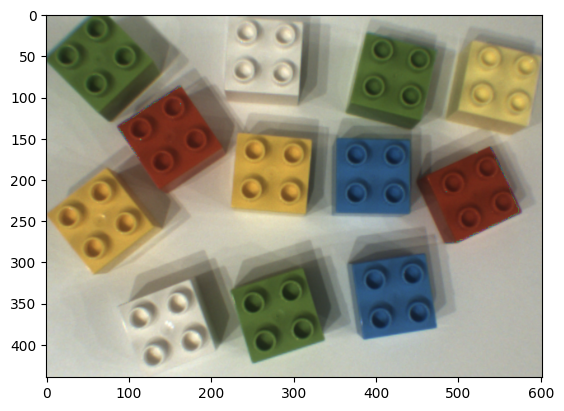

Color mask: white
Number of contours: 2
Number of bricks: 2


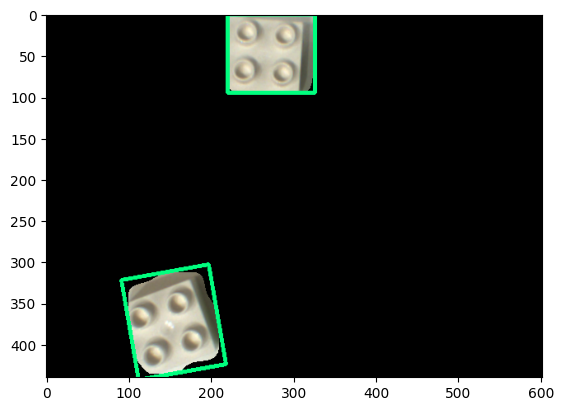

Color mask: red
Number of contours: 5
Number of bricks: 2


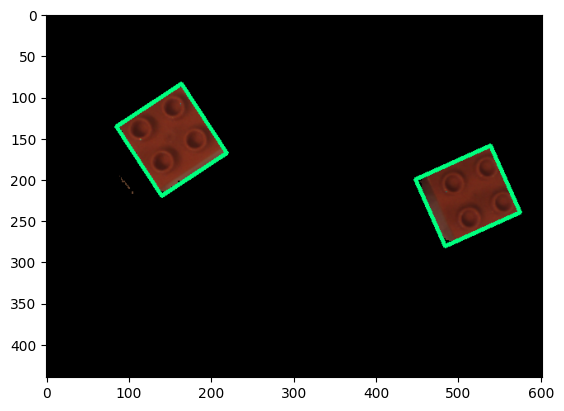

Color mask: green
Number of contours: 71
Number of bricks: 3


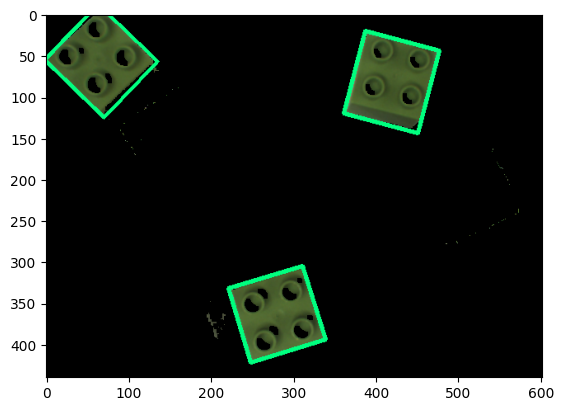

Color mask: blue
Number of contours: 41
Number of bricks: 2


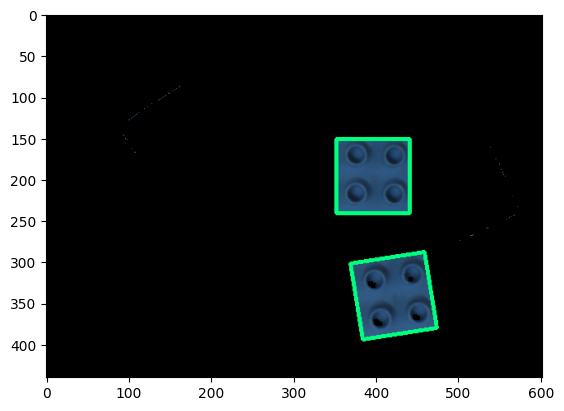

Color mask: yellow
Number of contours: 33
Number of bricks: 3


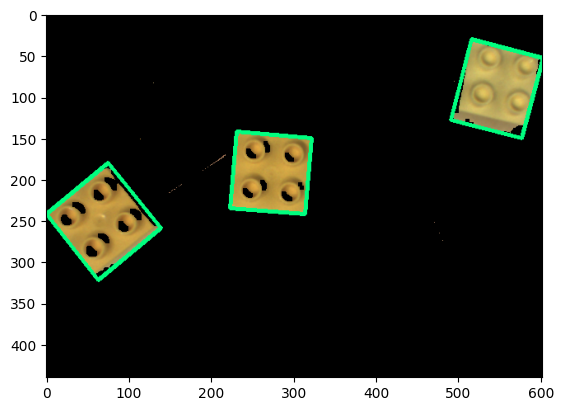

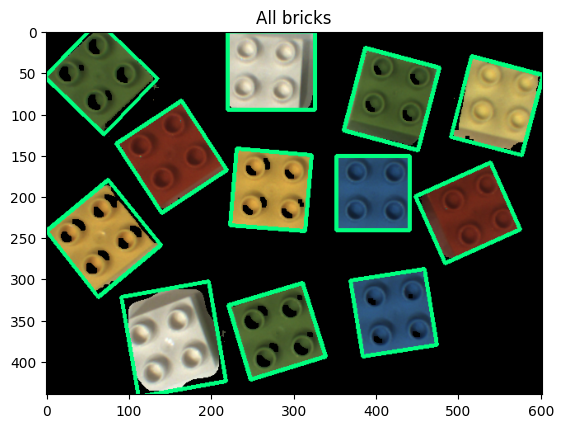

In [10]:
# Load image
img_col_bricks = cv2.imread(f'{FOLDER_PATH_ISOLATED}colored_bricks.png', cv2.IMREAD_COLOR)
img_col_bricks = cv2.cvtColor(img_col_bricks, cv2.COLOR_BGR2HSV)
img_col_bricks = undistort_image(img_col_bricks, best_calib_attempt["intrinsic_matrix"], best_calib_attempt["distortion_coeff"], crop=True)

## DEBUG ----
print("Original image: ")
plt.imshow( cv2.cvtColor(img_col_bricks, cv2.COLOR_HSV2RGB) )
plt.show()
## DEBUG ----

# Group by color
masked_colors: dict[str, cv2.Mat] = {}
for color_name, hsv_value in COLOR_DICT.items():
    # Ranges
    lower_bound, upper_bound = color_range(hsv_value)

    if color_name == "white": edge_mask = edge_detect(img_col_bricks, num_attempts=100, debug=False)

    #else:

    # Masked image
    mask       = cv2.inRange(img_col_bricks, lower_bound, upper_bound)
    if color_name == "white": mask = cv2.bitwise_and(mask, mask, mask=edge_mask); mask = edge_mask

    kernel = np.ones((5, 5), np.uint8)
    mask   = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel, iterations=1)  # Fill holes in mask

    img_result = cv2.bitwise_and(img_col_bricks, img_col_bricks, mask=mask)

    # Find contours
    contours, hierarchy = cv2.findContours(mask, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

    num_brick: int      = 0
    for c in contours:
        if cv2.contourArea(c) >= CONTOUR_AREA_THRESHOLD:
            # Bounding rectangles
            # x, y, w, h = cv2.boundingRect(c)
            rect       = cv2.minAreaRect(c)
            box        = cv2.boxPoints(rect)
            box        = np.intp(box)

            # Draw oriented rectangle
            cv2.drawContours(img_result, [box], 0, (255, 255, 255), 3)

            num_brick += 1

    # Store images
    masked_colors[color_name] = img_result

    ## DEBUG ----
    print(f"Color mask: {color_name}")
    print(f"Number of contours: {len(contours)}")
    print(f"Number of bricks: {num_brick}")
    plt.imshow( cv2.cvtColor(img_result, cv2.COLOR_HSV2RGB) )
    plt.show()
    ## DEBUG ----

# Overall
overall_img = np.zeros_like(img_col_bricks)
for _, mat in masked_colors.items():
    overall_img = cv2.bitwise_or(overall_img, mat)

## DEBUG ----
plt.imshow(cv2.cvtColor(overall_img, cv2.COLOR_HSV2RGB))
plt.title("All bricks")
plt.show()
## DEBUG ----

c)

In [11]:
# Data structure to store all detected bricks
brick_data = {
    "2x1": [],
    "2x2": [],
    "2x4": [],
    "2x6": [],
    "R2x2": []
}

### Quick Notes on auxiliary function

-> classify_brick_size: Calculates both the expected area and the actual area of the bounding box; compares those two values and checks if the error is within a predefined tolerance. In the end, classifies the brick considering the error.

In [12]:
# Auxiliary Function
def classify_brick_size(w_px: float, h_px: float, mm_per_px: float, area_px: float) -> str:
    w_mm: float = w_px * mm_per_px
    h_mm: float = h_px * mm_per_px
    # Width should be the larger dimension for comparison
    if h_mm > w_mm:
        w_mm, h_mm = h_mm, w_mm

    # Find best brick match
    best_match: str  = "unknown"
    min_error: float = float("inf")
    TOLERANCE: float = 0.9
    for brick_name, dims in TABLE_OF_BRICKS.items():
        # Sides and Area
        expected_w: int = max(dims[LENGTH], dims[WIDTH])
        expected_h: int = min(dims[LENGTH], dims[WIDTH])

        real_area: float     = area_px * (mm_per_px ** 2)
        expected_area: float = expected_w * expected_h * TOLERANCE

        # Error
        error: float         = abs(w_mm - expected_w) + abs(h_mm - expected_h)
        if (error < min_error) and (expected_area < real_area):
            min_error: float = error
            best_match: str  = brick_name

    return best_match

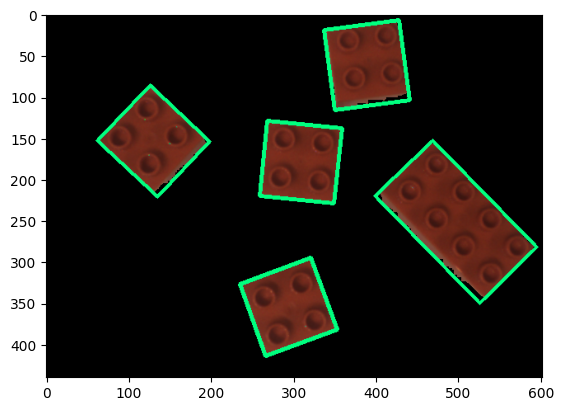

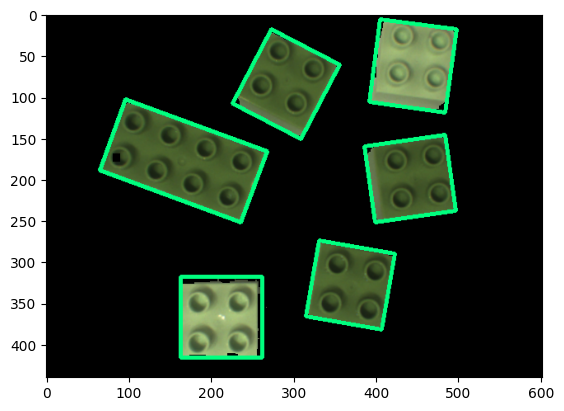

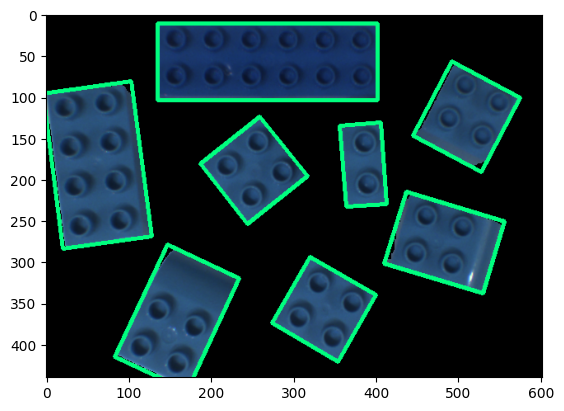

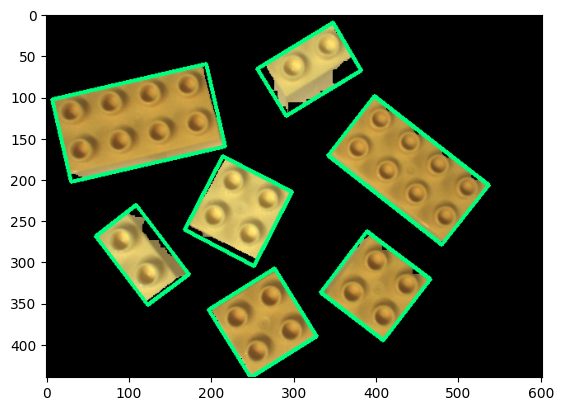


Brick Size Statistics Table:
Size Avg Area (pixel) Avg Area (mm²) Std Dev (mm²)
 2x1          5182.00         672.77         52.39
 2x2          8399.40        1090.48         33.01
 2x4         17158.30        2227.64        210.92
 2x6         24165.50        3137.37          0.00
R2x2         11996.00        1557.42        162.55

Total bricks identified: 26
  2x1: 3 brick(s)
  2x2: 15 brick(s)
  2x4: 5 brick(s)
  2x6: 1 brick(s)
  R2x2: 2 brick(s)


In [13]:
for color_name, hsv_value in COLOR_DICT.items():
    if color_name == "white": continue

    # Load Image
    img_bricks = cv2.imread(f"{FOLDER_PATH_ISOLATED + color_name}.png")
    img_bricks = cv2.cvtColor(img_bricks, cv2.COLOR_BGR2HSV)
    img_bricks = undistort_image(img_bricks, best_calib_attempt["intrinsic_matrix"], best_calib_attempt["distortion_coeff"], crop=True)

    # Ranges
    lower_bound, upper_bound = color_range(hsv_value)

    # Masked image
    mask       = cv2.inRange(img_bricks, lower_bound, upper_bound)

    kernel = np.ones((5, 5), np.uint8)
    mask   = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel, iterations=2)  # Fill holes in mask

    img_result = cv2.bitwise_and(img_bricks, img_bricks, mask=mask)

    # Find contours
    contours, hierarchy = cv2.findContours(mask, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

    num_brick: int      = 0
    for c in contours:
        area_px = cv2.contourArea(c)
        if area_px >= CONTOUR_AREA_THRESHOLD:
            # Bounding rectangles
            x, y, w, h  = cv2.boundingRect(c)
            ## DEBUG ----
            rect = cv2.minAreaRect(c)
            box = cv2.boxPoints(rect)
            box = np.intp(box)

            # Draw oriented rectangle
            cv2.drawContours(img_result, [box], 0, (255, 255, 255), 3)
            ## DEBUG ----

            area_mm2 = area_px * (mm_per_px ** 2)

            # Classify size
            brick_size = classify_brick_size(w, h, mm_per_px, area_px)

            if brick_size != "unknown":
                brick_data[brick_size].append({
                    "color": color_name,
                    "area_px": area_px,
                    "area_mm2": area_mm2,
                    "w_px": w,
                    "h_px": h
                })

    ## DEBUG ----
    plt.imshow( cv2.cvtColor(img_result, cv2.COLOR_HSV2RGB) )
    plt.show()
    ## DEBUG ----

# Build summary table
table_rows: list = []
for size_name in ["2x1", "2x2", "2x4", "2x6", "R2x2"]:
    bricks = brick_data[size_name]
    count = len(bricks)
    if count > 0:
        areas_px = [b["area_px"] for b in bricks]
        areas_mm = [b["area_mm2"] for b in bricks]
        avg_area_px = np.mean(areas_px)
        avg_area_mm = np.mean(areas_mm)
        std_area_mm = np.std(areas_mm)
    else:
        avg_area_px = 0.0
        avg_area_mm = 0.0
        std_area_mm = 0.0

    table_rows.append({
        "Size": size_name,
        "Avg Area (pixel)": f"{avg_area_px:.2f}",
        "Avg Area (mm²)": f"{avg_area_mm:.2f}",
        "Std Dev (mm²)": f"{std_area_mm:.2f}"
    })

df_stats = pd.DataFrame(table_rows)
print("\nBrick Size Statistics Table:")
print(df_stats.to_string(index=False))

## DEBUG ----
print(f"\nTotal bricks identified: {sum(len(v) for v in brick_data.values())}")
for size_name, bricks in brick_data.items():
    if len(bricks) > 0:
        print(f"  {size_name}: {len(bricks)} brick(s)")
## DEBUG ----

---

## 3. Kit images

a)

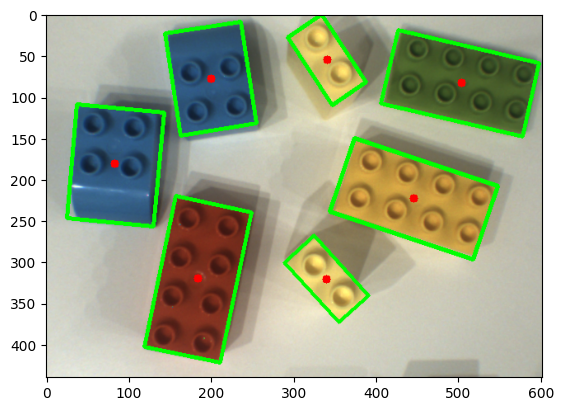

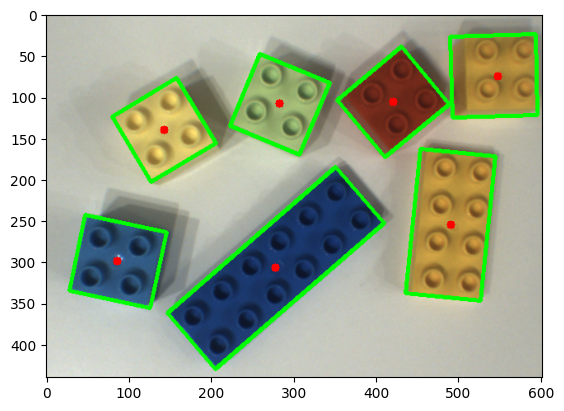

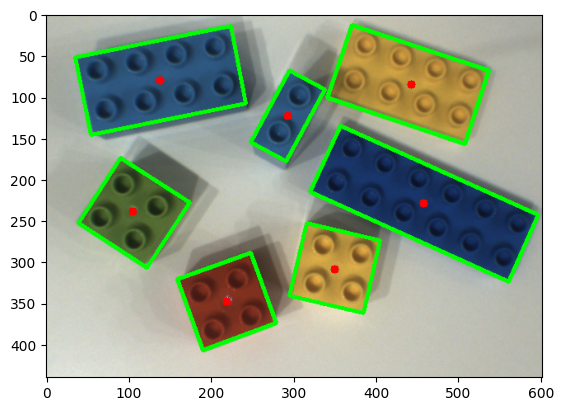

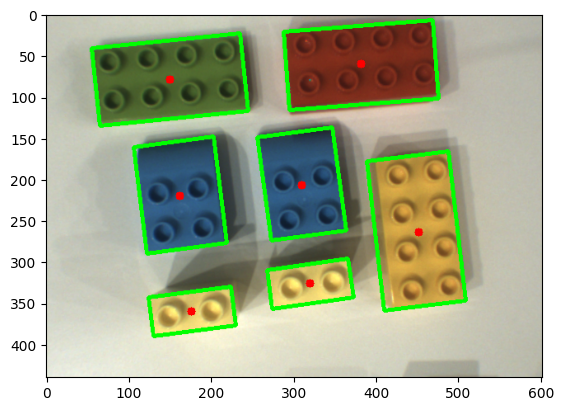

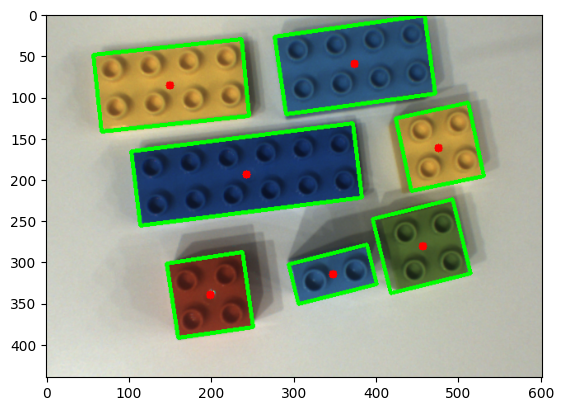

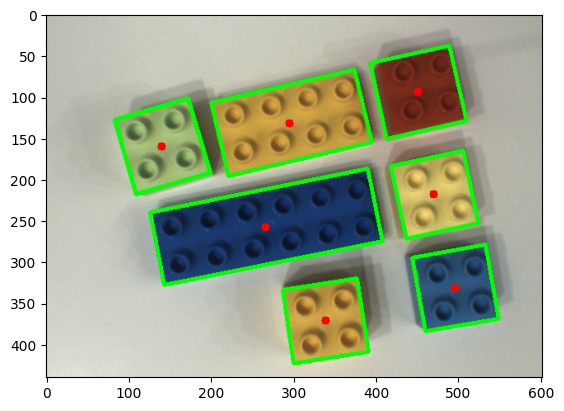

In [14]:
# Get list of kit images
kit_images: list = []
for file in os.listdir(FOLDER_PATH_KIT):
    kit_images.append(file)

detected_bricks: list = []
for kit_img_name in sorted(kit_images):

    # Load and preprocess image
    img_kit = cv2.imread(FOLDER_PATH_KIT + kit_img_name)
    img_kit = cv2.cvtColor(img_kit, cv2.COLOR_BGR2RGB)
    img_kit_undist = undistort_image(
        cv2.cvtColor(img_kit, cv2.COLOR_RGB2HSV),
        best_calib_attempt["intrinsic_matrix"],
        best_calib_attempt["distortion_coeff"],
        crop=True
    )

    # Create visualization image
    img_display = cv2.cvtColor(img_kit_undist.copy(), cv2.COLOR_HSV2RGB)

    # Detect bricks by color
    for color_name, hsv_value in COLOR_DICT.items():
        if color_name == "white":
            continue

        # Mask
        lower_bound, upper_bound = color_range(hsv_value)
        mask = cv2.inRange(img_kit_undist, lower_bound, upper_bound)

        # Find contours
        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        for c in contours:
            area_px = cv2.contourArea(c)
            if area_px >= CONTOUR_AREA_THRESHOLD:
                # Get bounding box
                x, y, w, h = cv2.boundingRect(c)

                # Calculate centroid
                M = cv2.moments(c)
                if M["m00"] != 0:
                    cx = int(M["m10"] / M["m00"])
                    cy = int(M["m01"] / M["m00"])
                else:
                    cx, cy = x + w//2, y + h//2

                # Classify brick size
                brick_size = classify_brick_size(w, h, mm_per_px, area_px)
                ## NOTES: Should we confirm if the name is "unkown"?
                detected_bricks.append({
                    "Image": kit_img_name,
                    "Size": brick_size,
                    "Color": color_name,
                    "Quantity": 1
                })

                # Draw bounding box
                rect = cv2.minAreaRect(c)
                box = cv2.boxPoints(rect)
                box = np.intp(box)

                # Draw oriented rectangle
                cv2.drawContours(img_display, [box], 0, (0, 255, 0), 3)

                # Draw centroid
                cv2.circle(img_display, (cx, cy), 5, (255, 0, 0), -1)

    # Display results
    plt.imshow(img_display)
    plt.show()

b)

In [15]:
# Group and sum quantities
grouped = defaultdict(int)
for detection in detected_bricks:
    key = (detection["Image"], detection["Size"], detection["Color"])
    grouped[key] += 1

# Build final table
table_data: list = []
current_image = None
for (image, size, color), qty in sorted(grouped.items()):
    table_data.append({
        "Image": image if image != current_image else "",
        "Size": size,
        "Color": color,
        "Quantity": qty
    })
    current_image = image

df_table = pd.DataFrame(table_data)
print("\nBrick Count Table:")
print(df_table.to_string(index=False))



Brick Count Table:
         Image Size  Color  Quantity
ImageA_kit.png  2x1 yellow         2
                2x4  green         1
                2x4    red         1
                2x4 yellow         1
               R2x2   blue         2
ImageB_kit.png  2x2   blue         1
                2x2  green         1
                2x2    red         1
                2x2 yellow         2
                2x4 yellow         1
                2x6   blue         1
ImageC_kit.png  2x1   blue         1
                2x2  green         1
                2x2    red         1
                2x2 yellow         1
                2x4   blue         1
                2x4 yellow         1
                2x6   blue         1
      kit1.png  2x1 yellow         2
                2x4  green         1
                2x4    red         1
                2x4 yellow         1
               R2x2   blue         2
      kit2.png  2x1   blue         1
                2x2  green         1
                2x

c)

In [16]:
## DEBUG ----
# print(f"{grouped = }")
## DEBUG ----

# Split kits from images
kits_dict: dict[str, list[tuple]]   = {}
images_dict: dict[str, list[tuple]] = {}
for (image, size, color), qty in sorted(grouped.items()):
    if "Image" in image:
        if image not in images_dict: images_dict[str(image)] = []
        images_dict[str(image)].append( (size, color, qty) )
    else:
        if image not in kits_dict: kits_dict[str(image)] = []
        kits_dict[str(image)].append( (size, color, qty) )


## DEBUG ----
# print(f"{kits_dict = }")
# print(f"{images_dict = }")
## DEBUG ----

# Compare kits
image_kit_match: list[tuple] = []
for image, image_lego_list in images_dict.items():
    for kit, kit_lego_list in kits_dict.items():
        if image_lego_list == kit_lego_list:
            image_kit_match.append( (image, kit) )


## DEBUG ----
# print(f"{image_kit_match = }")
## DEBUG ----

# Prints
# tup: (image_name, kit_name)
for tup in image_kit_match:
    print(f"Image {tup[0]} corresponds to kit {tup[1]}.")

Image ImageA_kit.png corresponds to kit kit1.png.
Image ImageB_kit.png corresponds to kit kit3.png.
Image ImageC_kit.png corresponds to kit kit2.png.


d)

To mitigate photometric effects, the Lego factory should ensure consistent and diffuse lighting across the inspection area to minimize shadows and reflections that interfere with color and shape detection.

Additionally, the system could benefit from using calibration images captured under varying lighting conditions and with different backgrounds, which would help reduce re-projection error and improve the precision of the intrinsic parameters.

When it comes to detection accuracy, there are a few aspects that should be considered, though spacing and orientation are the most crucial. The Lego bricks should be evenly spaced and consistently oriented (facing upwards in either a vertical or a horizontal alignment) to ensure the system can clearly detect the contours and identify more reliably features during image processing. To enable reliable detection of all bricks, a uniform matte background should be used to provide strong contrast with every brick color, especially white bricks.

---

## 4. Fault Images

ImageA_fault.png


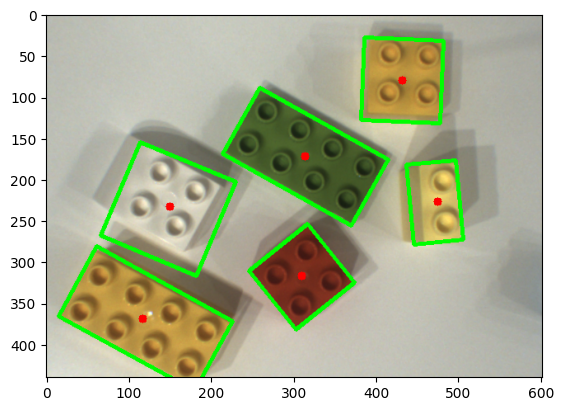

ImageB_fault.png


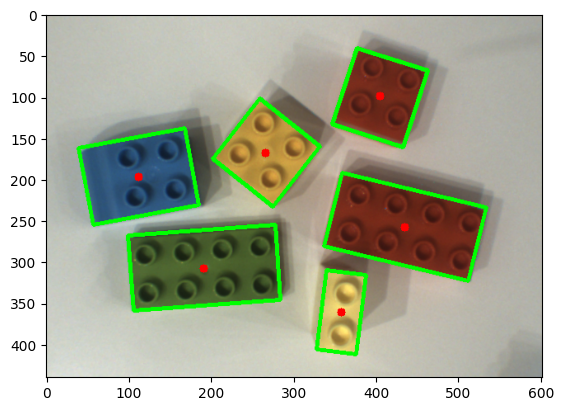

ImageC_fault.png


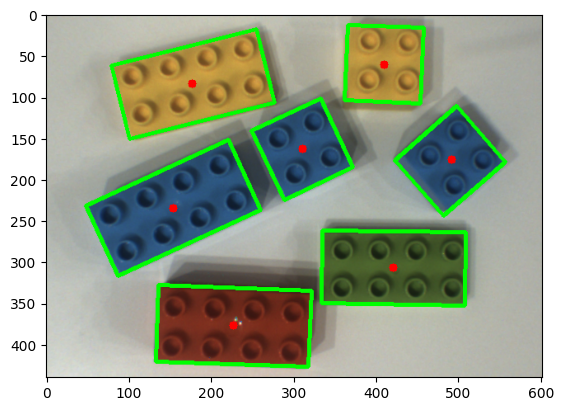

ImageD_fault.png


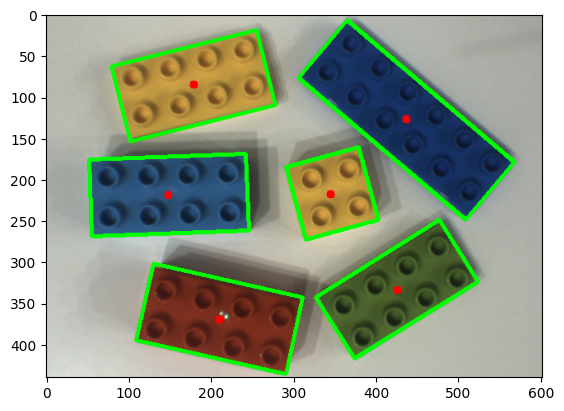

ImageE_fault.png


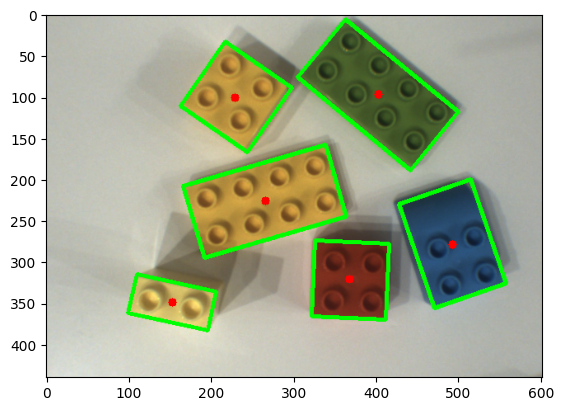

ImageF_fault.png


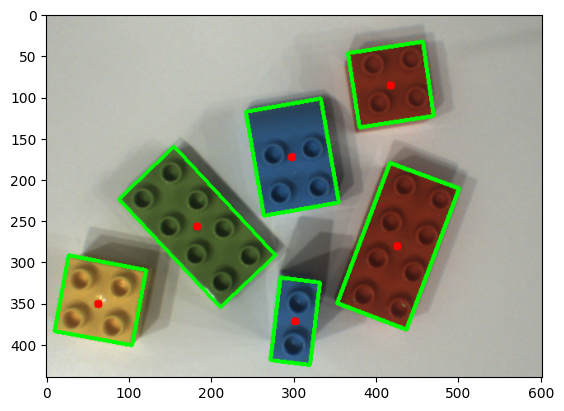

kitA.png


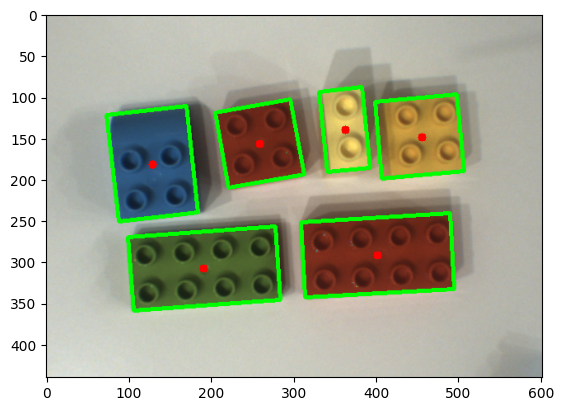

kitB.png


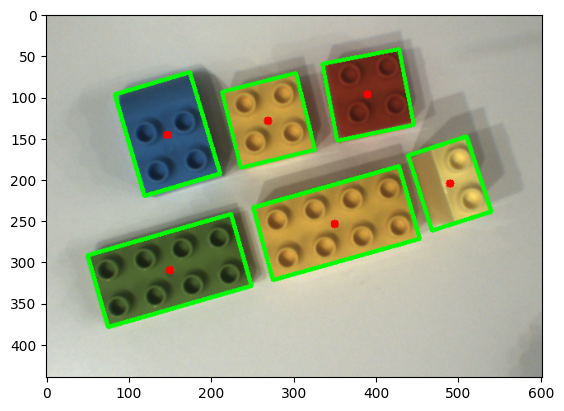

kitC.png


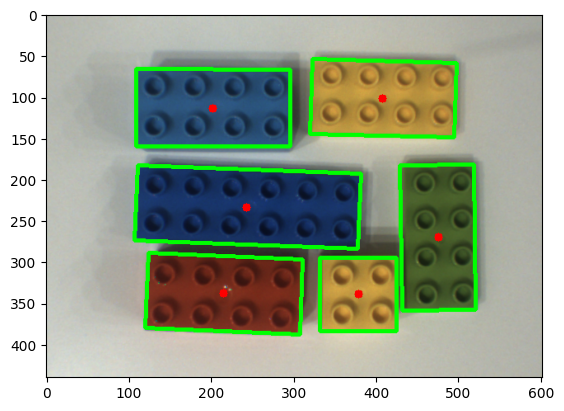

In [17]:
## ---- Same as previous exercises ----

# Get list of kit images
kit_images: list = []
for file in os.listdir(FOLDER_PATH_FAULT):
    kit_images.append(file)

detected_bricks: list = []
for kit_img_name in sorted(kit_images):

    # Load and preprocess image
    img_kit = cv2.imread(FOLDER_PATH_FAULT + kit_img_name)
    img_kit = cv2.cvtColor(img_kit, cv2.COLOR_BGR2RGB)
    img_kit_undist = undistort_image(
        cv2.cvtColor(img_kit, cv2.COLOR_RGB2HSV),
        best_calib_attempt["intrinsic_matrix"],
        best_calib_attempt["distortion_coeff"],
        crop=True
    )

    # Create visualization image
    img_display = cv2.cvtColor(img_kit_undist.copy(), cv2.COLOR_HSV2RGB)

    # Detect bricks by color
    for color_name, hsv_value in COLOR_DICT.items():
        # if color_name == "white":
        #     continue
        if color_name == "white": edge_mask = edge_detect(img_kit_undist, num_attempts=160, debug=False)

        # Mask
        lower_bound, upper_bound = color_range(hsv_value)
        mask = cv2.inRange(img_kit_undist, lower_bound, upper_bound)
        if color_name == "white": mask = cv2.bitwise_and(mask, mask, mask=edge_mask)

        # Find contours
        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        for c in contours:
            area_px = cv2.contourArea(c)
            if area_px >= CONTOUR_AREA_THRESHOLD:
                # Get bounding box
                x, y, w, h = cv2.boundingRect(c)

                # Calculate centroid
                M = cv2.moments(c)
                if M["m00"] != 0:
                    cx = int(M["m10"] / M["m00"])
                    cy = int(M["m01"] / M["m00"])
                else:
                    cx, cy = x + w//2, y + h//2

                # Classify brick size
                brick_size = classify_brick_size(w, h, mm_per_px, area_px)
                ## NOTES: Should we confirm if the name is "unkown"
                detected_bricks.append({
                    "Image": kit_img_name,
                    "Size": brick_size,
                    "Color": color_name,
                    "Quantity": 1
                })

                # Draw bounding box
                rect = cv2.minAreaRect(c)
                box = cv2.boxPoints(rect)
                box = np.intp(box)

                # Draw oriented rectangle
                cv2.drawContours(img_display, [box], 0, (0, 255, 0), 3)

                # Draw centroid
                cv2.circle(img_display, (cx, cy), 5, (255, 0, 0), -1)

    # Display results
    print(f"{kit_img_name}")
    plt.imshow(img_display)
    plt.show()


# Group and sum quantities
grouped = defaultdict(int)
for detection in detected_bricks:
    key = (detection["Image"], detection["Size"], detection["Color"])
    grouped[key] += 1


# Split kits from images
kits_dict: dict[str, list[tuple]]   = {}
images_dict: dict[str, list[tuple]] = {}
for (image, size, color), qty in sorted(grouped.items()):
    if ("Image" in image) or ("image" in image):
        if image not in images_dict: images_dict[str(image)] = []
        images_dict[str(image)].append( (size, color, qty) )
    else:
        if image not in kits_dict: kits_dict[str(image)] = []
        kits_dict[str(image)].append( (size, color, qty) )

## ---- Same as previous exercises ----

In [18]:
## DEBUG ----
# print(f"{kits_dict = }")
# print(f"{images_dict = }")
## DEBUG ----

# Compare kits
image_kit_match: list[tuple] = []
image_fault: list[tuple]     = []
for image, image_lego_list in images_dict.items():
    not_fault: bool   = False

    # Check if it's correct
    for kit, kit_lego_list in kits_dict.items():
        if image_lego_list == kit_lego_list:
            image_kit_match.append( (image, kit) )
            not_fault = True
            break

    # Reason for being incorrect
    if not not_fault:
        debt: list[str, int, str] = [image, "", 0, ""]     # [Kit, Common Legos, Reason]

        for kit, kit_lego_list in kits_dict.items():
            # Get differences
            diff1          = list(set(image_lego_list) - set(kit_lego_list))
            diff2          = list(set(kit_lego_list)   - set(image_lego_list))
            symmetric_diff = list(set(image_lego_list).intersection(set(kit_lego_list)))


            ## DEBUG ----
            # print(f"{kit = }")

            # print(f"{diff1 = }")
            # print(f"{diff2 = }")
            # print(f"{symmetric_diff = }")

            # print("")
            ## DEBUG ----


            if len(symmetric_diff) > debt[2]:
                debt[1] = kit
                debt[2] = len(symmetric_diff)
                debt[3] = f"Kit contains:   {kit_lego_list} \nImage Contains: {image_lego_list} \nCommon Bricks:  {symmetric_diff} \nMissing Legos:  {diff2} \nExtra Legos:    {diff1} \n"


        image_fault.append( tuple(debt) )


## DEBUG ----
print("Matches: ")
for matches in image_kit_match:
    print(matches)

print("\nFaults:")
for img_fault in image_fault:
    print( (img_fault[0], img_fault[1]) )
    print(img_fault[3])
## DEBUG ----


Matches: 
('ImageB_fault.png', 'kitA.png')
('ImageD_fault.png', 'kitC.png')
('ImageE_fault.png', 'kitB.png')

Faults:
('ImageA_fault.png', 'kitB.png')
Kit contains:   [('2x1', 'yellow', 1), ('2x2', 'red', 1), ('2x2', 'yellow', 1), ('2x4', 'green', 1), ('2x4', 'yellow', 1), ('R2x2', 'blue', 1)] 
Image Contains: [('2x1', 'yellow', 1), ('2x2', 'red', 1), ('2x2', 'yellow', 1), ('2x4', 'green', 1), ('2x4', 'yellow', 1), ('R2x2', 'white', 1)] 
Common Bricks:  [('2x2', 'red', 1), ('2x4', 'yellow', 1), ('2x1', 'yellow', 1), ('2x4', 'green', 1), ('2x2', 'yellow', 1)] 
Missing Legos:  [('R2x2', 'blue', 1)] 
Extra Legos:    [('R2x2', 'white', 1)] 

('ImageC_fault.png', 'kitC.png')
Kit contains:   [('2x2', 'yellow', 1), ('2x4', 'blue', 1), ('2x4', 'green', 1), ('2x4', 'red', 1), ('2x4', 'yellow', 1), ('2x6', 'blue', 1)] 
Image Contains: [('2x2', 'blue', 2), ('2x2', 'yellow', 1), ('2x4', 'blue', 1), ('2x4', 'green', 1), ('2x4', 'red', 1), ('2x4', 'yellow', 1)] 
Common Bricks:  [('2x4', 'red', 1), (